In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from lib.util import *
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

/Users/neiljanwani/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMU_FILE = r'AB06/ik.csv'
GC_FILE = r'AB06/fsr.csv'
START, END = 15, 140

In [3]:
ik_df = pd.read_csv(IMU_FILE).astype('float').set_index('Header')
labels_df = pd.read_csv(GC_FILE).astype('float').set_index('Header') / 100
ik_df = ik_df[START:END]
labels_df = labels_df[START:END]
ik_df = pd.concat((ik_df, labels_df['HeelStrike']),axis=1)
ik_df

pelvis_tilt  pelvis_list  pelvis_rotation  pelvis_tx  pelvis_ty  \
Header                                                                     
15.000      1.175642    -1.589459        94.411600   0.561566   0.968721   
15.005      1.204891    -1.595422        94.460210   0.562587   0.968953   
15.010      1.232558    -1.593316        94.501539   0.563593   0.969188   
15.015      1.254576    -1.601415        94.537536   0.564597   0.969385   
15.020      1.282050    -1.596200        94.569654   0.565598   0.969607   
...              ...          ...              ...        ...        ...   
139.980     1.511324     1.094546        93.321525   0.601520   0.976013   
139.985     1.490107     1.120095        93.256778   0.601785   0.976032   
139.990     1.472514     1.143496        93.195324   0.602031   0.976021   
139.995     1.471834     1.113577        93.137640   0.602264   0.975926   
140.000     1.449932     1.187905        93.081780   0.602469   0.975930   

         pelvis_tz  hip_flexion_r  hip_adduction_r  hip_rotation_r  \
Header                                                               
15.000   -0.878552      17.653813        -0.621336       -9.500425   
15.005   -0.878401      17.463925        -0.531898       -9.620766   
15.010   -0.878243      17.265289        -0.443170       -9.737032   
15.015   -0.878050      17.092163        -0.364185       -9.857048   
15.020   -0.877855      16.894537        -0.275487       -9.976007   
...            ...            ...              ...             ...   
139.980  -0.924320       5.580493         2.086038      -10.733721   
139.985  -0.923830       5.213495         2.108346      -10.723630   
139.990  -0.923334       4.851605         2.132528      -10.719037   
139.995  -0.922792       4.552342         2.173140      -10.696201   
140.000  -0.922337       4.127238         2.192161      -10.707039   

         knee_angle_r  ...  hip_adduction_l  hip_rotation_l  knee_angle_l  \
Header                 ...                                                  
15.000     -16.724642  ...        -3.576989        0.016473    -33.165010   
15.005     -16.648215  ...        -3.712303       -0.045267    -34.210391   
15.010     -16.570153  ...        -3.844853       -0.117889    -35.262001   
15.015     -16.518079  ...        -3.971275       -0.198809    -36.329803   
15.020     -16.441650  ...        -4.101657       -0.279666    -37.396361   
...               ...  ...              ...             ...           ...   
139.980    -15.766617  ...        -4.231384       -3.002660    -62.365319   
139.985    -15.621106  ...        -4.190338       -3.043499    -61.784090   
139.990    -15.480403  ...        -4.150707       -3.077703    -61.158164   
139.995    -15.340152  ...        -4.118929       -3.090632    -60.494924   
140.000    -15.190979  ...        -4.078755       -3.121547    -59.772757   

         ankle_angle_l  subtalar_angle_l  mtp_angle_l  lumbar_extension  \
Header                                                                    
15.000       14.229442          0.061321          0.0               0.0   
15.005       13.659554          0.102917          0.0               0.0   
15.010       13.062758          0.116345          0.0               0.0   
15.015       12.449169          0.125762          0.0               0.0   
15.020       11.801328          0.071881          0.0               0.0   
...                ...               ...          ...               ...   
139.980       3.024124        -13.213268          0.0               0.0   
139.985       3.521463        -13.214727          0.0               0.0   
139.990       3.983908        -13.268263          0.0               0.0   
139.995       4.396140        -13.369447          0.0               0.0   
140.000       4.793917        -13.469422          0.0               0.0   

         lumbar_bending  lumbar_rotation  HeelStrike  
Header                                                
15.000              0

In [4]:
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(labels_df, labels=dict(created_at="Date", value='Percent gait', Header='Time (s)'))
fig.show()

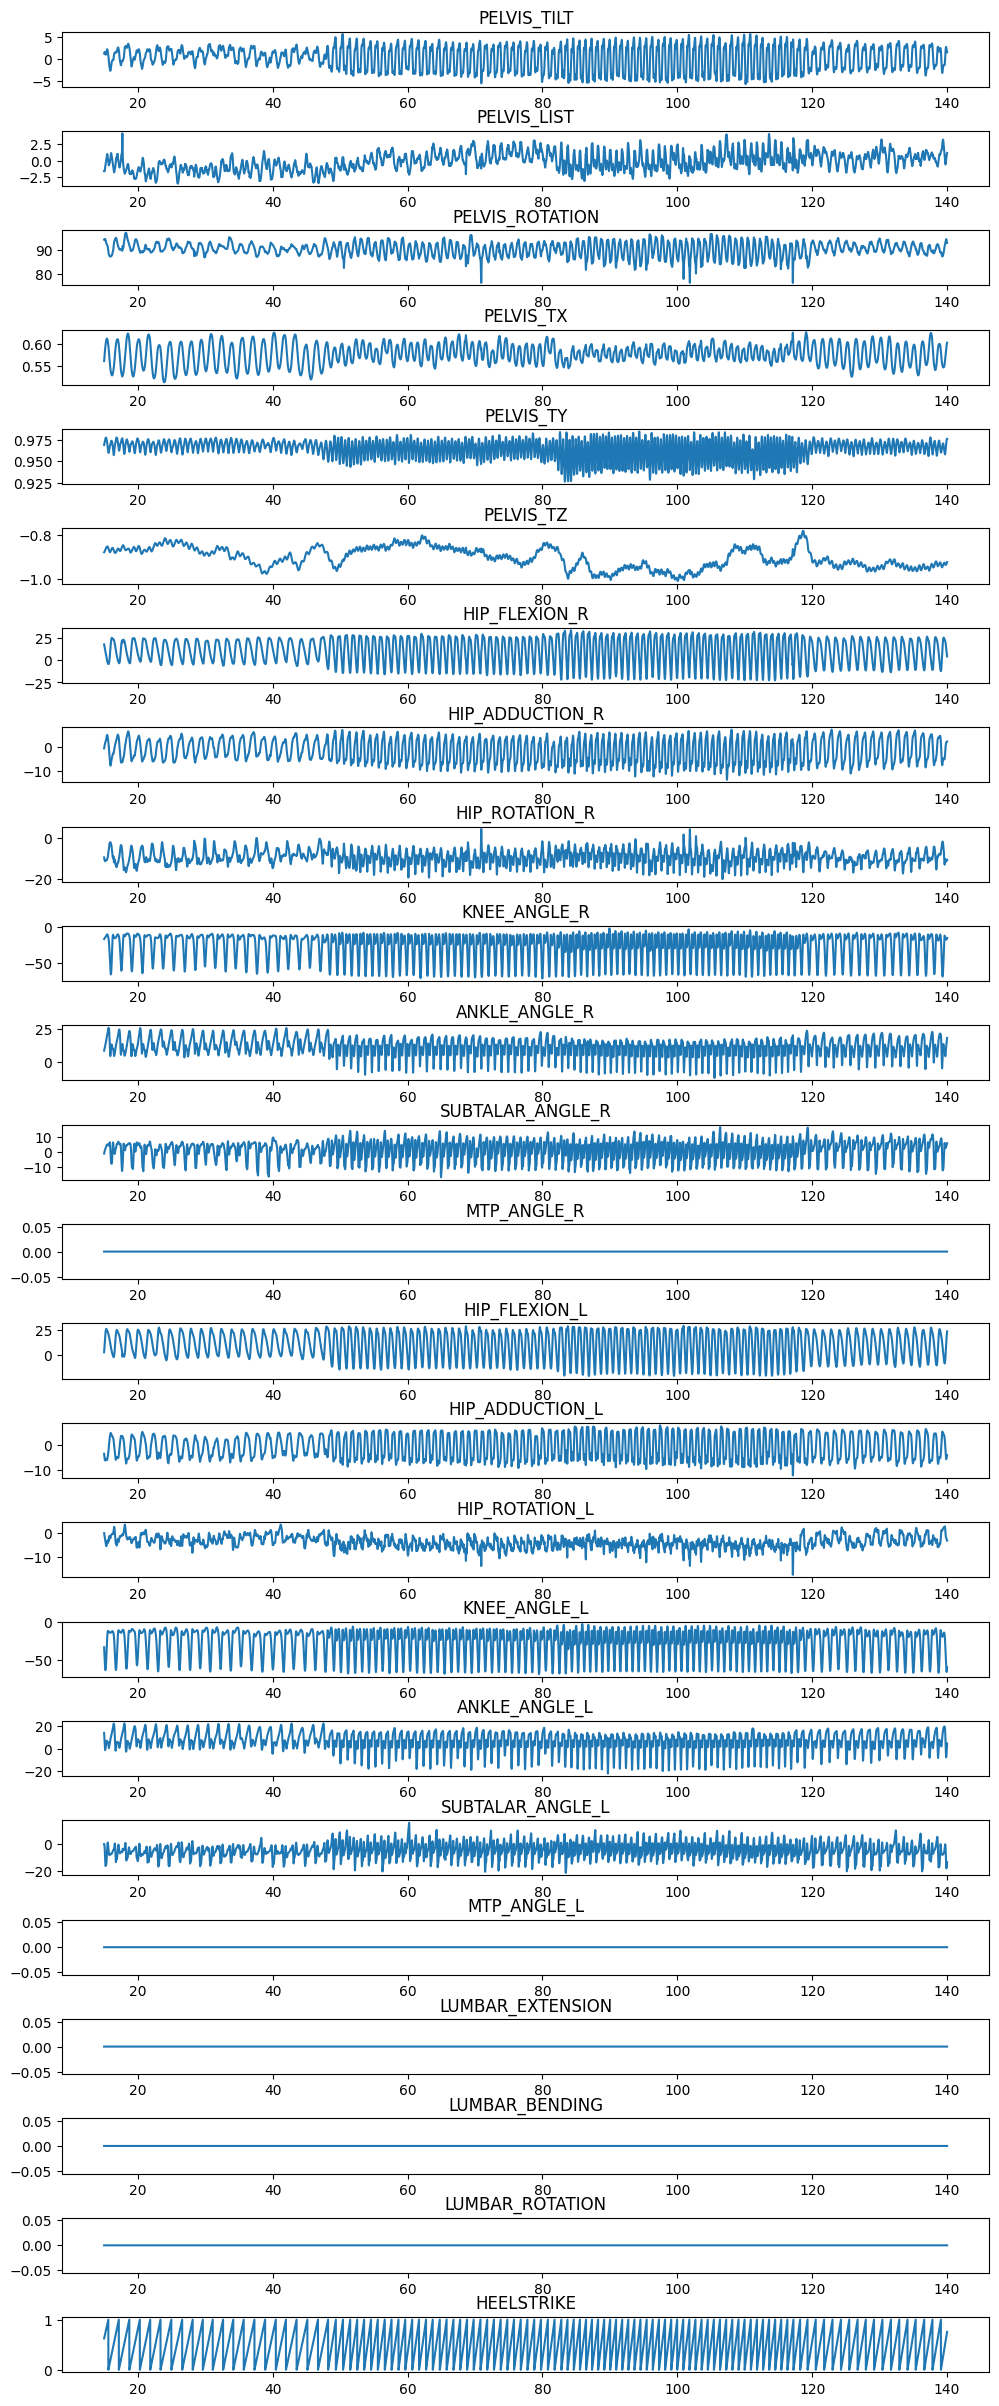

In [5]:
plot(ik_df,1)

In [6]:
target_sensor = 'HeelStrike'
features = ['ankle_angle_l', 'subtalar_angle_l']
            # 'ankle_angle_r', 'subtalar_angle_r',
            # 'pelvis_tilt', 'pelvis_list', 'pelvis_tx', 'pelvis_ty', 'pelvis_tz']
forecast_lead = 15
target = f"{target_sensor}_lead{forecast_lead}"

ik_df[target] = ik_df[target_sensor].shift(-forecast_lead)
ik_df = ik_df.iloc[:-forecast_lead]
features

['ankle_angle_l', 'subtalar_angle_l']

In [7]:
test_start = 130

df_train = ik_df.loc[:test_start].copy()
df_test = ik_df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(ik_df))

Test set fraction: 0.07948451132634275


In [8]:
# target_mean = df_train[target].mean()
# target_stdev = df_train[target].std()

# for c in df_train.columns:
#     mean = df_train[c].mean()
#     stdev = df_train[c].std()

#     df_train[c] = (df_train[c] - mean) / stdev
#     df_test[c] = (df_test[c] - mean) / stdev

In [9]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [10]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 1000

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 1000, 2])
Target shape: torch.Size([4])


In [11]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [12]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in tqdm(data_loader):
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.6319143145665587

Epoch 0
---------


100%|██████████| 5751/5751 [07:18<00:00, 13.11it/s]  


Train loss: 0.1377617556508262
Test loss: 0.0363975954238958

Epoch 1
---------


100%|██████████| 5751/5751 [06:49<00:00, 14.06it/s]


Train loss: 0.037759791662536395
Test loss: 0.015447369623014628

Epoch 2
---------


100%|██████████| 5751/5751 [06:52<00:00, 13.93it/s]


Train loss: 0.028381738472515277
Test loss: 0.011326824743198417

Epoch 3
---------


100%|██████████| 5751/5751 [06:46<00:00, 14.14it/s]


Train loss: 0.020980999234819407
Test loss: 0.010644338573765745

Epoch 4
---------


100%|██████████| 5751/5751 [06:49<00:00, 14.04it/s]


Train loss: 0.016235757259356803
Test loss: 0.009291862532361314



In [14]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print('Before pre-processing')
print(df_out)
print(df_out['Model forecast'])

# last = 1
# for i in range(len(df_out[ystar_col])):
#     if df_out[ystar_col] < 0.7 and df_out[ystar_col] - last < 0:
#         df_out[ystar_col] = last
#post process for strictly in creasing(ish)

Before pre-processing
         HeelStrike_lead15  Model forecast
Header                                    
15.000            0.669670        0.530801
15.005            0.672673        0.528074
15.010            0.675676        0.523149
15.015            0.678679        0.516180
15.020            0.681682        0.508206
...                    ...             ...
139.905           0.739669        0.769979
139.910           0.743802        0.769017
139.915           0.747934        0.767380
139.920           0.752066        0.765068
139.925           0.756198        0.762338

[24987 rows x 2 columns]
Header
15.000     0.530801
15.005     0.528074
15.010     0.523149
15.015     0.516180
15.020     0.508206
             ...   
139.905    0.769979
139.910    0.769017
139.915    0.767380
139.920    0.765068
139.925    0.762338
Name: Model forecast, Length: 24987, dtype: float32


In [15]:
LENGTH = 10
running = [0] * LENGTH
arr = list(df_out[ystar_col])
new_arr = [0] * len(arr)
for i in range(len(arr)):
    idx = i % LENGTH
    running[idx] = arr[i]
    new_arr[i] = np.mean(running)

print('After')
print(new_arr)

After
[0.05308011770248413, 0.1058875322341919, 0.15820243954658508, 0.20982043147087098, 0.260641074180603, 0.31058273613452914, 0.3595389723777771, 0.40757052004337313, 0.45488840341567993, 0.5019221037626267, 0.4962624251842499, 0.492097869515419, 0.49050221145153045, 0.49239947497844694, 0.498369625210762, 0.5086975157260895, 0.5234220057725907, 0.5423860490322113, 0.5650993257761001, 0.5909222662448883, 0.6189426332712173, 0.6480867087841033, 0.6774059534072876, 0.7061817705631256, 0.7340830981731414, 0.7610965132713318, 0.7873617172241211, 0.8125451028347015, 0.8360644400119781, 0.8570516407489777, 0.8748471081256867, 0.889165335893631, 0.8999394536018371, 0.9072636425495147, 0.9112025678157807, 0.9118163287639618, 0.9092591583728791, 0.9041541039943695, 0.897524631023407, 0.8905715823173523, 0.8842814862728119, 0.8792569816112519, 0.8756941854953766, 0.8735474169254303, 0.8726466000080109, 0.8727675795555114, 0.8737193048000336, 0.8753612220287323, 0.8775291740894318, 0.88015915

In [16]:
# df_out.drop('HeelStrike_lead15', axis=1)
# print(df_out)
# df_out.insert(0, 'averaged', new_arr)
# print(df_out)
df_out['averaged'] = new_arr
df_out
# print(list(df_out['Model forecast']))

HeelStrike_lead15  Model forecast  averaged
Header                                              
15.000            0.669670        0.530801  0.053080
15.005            0.672673        0.528074  0.105888
15.010            0.675676        0.523149  0.158202
15.015            0.678679        0.516180  0.209820
15.020            0.681682        0.508206  0.260641
...                    ...             ...       ...
139.905           0.739669        0.769979  0.778005
139.910           0.743802        0.769017  0.775717
139.915           0.747934        0.767380  0.773648
139.920           0.752066        0.765068  0.771740
139.925           0.756198        0.762338  0.769945

[24987 rows x 3 columns]

In [17]:
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df_out[:], labels=dict(created_at="Date", value='Percent gait', Header='Time (s)'))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
# fig.update_layout(
#     template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
# )
fig.show()
# fig, ax = plt.subplots()
# ax.plot(list(df_out[10:20].index), list(df_out['HeelStrike_lead15'][10:20]), label='Prediction')
# ax.plot(list(df_out[10:20].index), list(df_out['Model forecast'][10:20]), label='Truth')
# ax.set_title('Prediction vs. truth gaits')
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Percent gait')
# ax.legend()
# plt.show()

In [18]:
accuracies = np.linspace(0, 0.25, num=26)
predictions = [len([None for o, t in zip(df_out[:]['HeelStrike_lead15'], df_out[:]['Model forecast']) if min(1 - abs(o - t), abs(o - t)) <= close]) / len(df_out[:]) for close in accuracies]
averaged = [len([None for o, t in zip(df_out['HeelStrike_lead15'][:], df_out['averaged'][:]) if min(1 - abs(o - t), abs(o - t)) <= close]) / len(df_out[:]) for close in accuracies]

In [19]:
for cat, acc, avg in zip(accuracies, predictions, averaged):
    print(cat, acc, avg)

0.0 0.0 0.0
0.01 0.160083243286509 0.13495017409052706
0.02 0.31248249089526553 0.2702605354784488
0.03 0.4553567855284748 0.39360467443070396
0.04 0.5688558050186097 0.5154680433825589
0.05 0.6555008604474326 0.6140793212470484
0.06 0.7229759474926962 0.6920798815383999
0.07 0.7731620442630168 0.7513507023652299
0.08 0.8115420018409573 0.7938928242686197
0.09 0.8397566734702046 0.8280705967102894
0.1 0.863328931044143 0.8524832913114819
0.11 0.8790170888862209 0.870732781046144
0.12 0.8915836234842118 0.8836595029415296
0.13 0.9005482851082562 0.8945451634850122
0.14 0.9088726137591547 0.9035898667307
0.15 0.9163965261936207 0.9107135710569496
0.16 0.9220794813302917 0.9176371713290912
0.17 0.9271621243046384 0.9232000640332974
0.18 0.9326049545763797 0.9284828110617521
0.19 0.936767118901829 0.9327250170088446
0.2 0.9412494497138512 0.9367270980910073
0.21 0.945771801336695 0.9413294913354945
0.22 0.9493336534998199 0.9446111978228678
0.23 0.9532556929603394 0.9477328210669548
0.24 0

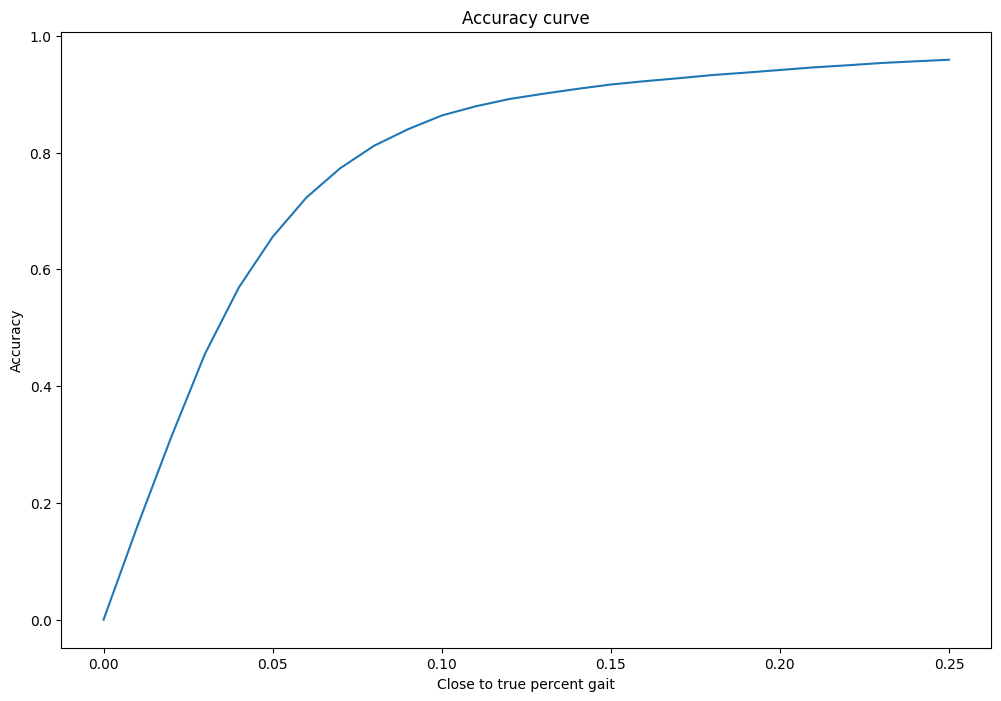

In [21]:
fig, ax = plt.subplots()
ax.plot([acc for acc in accuracies], predictions)
# ax.plot([acc for acc in accuracies], averaged)
fig.set_size_inches(12,8)
ax.set_title('Accuracy curve')
ax.set_xlabel('Close to true percent gait')
ax.set_ylabel('Accuracy')
plt.show()